In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
import os

from scipy import signal
from scipy import stats

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})
matplotlib.rc('pdf', fonttype=42)

In [3]:
# use fft to pull out frequency
def returnFFT(array, Fs):
    from scipy.fftpack import fft
    
    meanx = np.mean(array)
    fftr = fft(array - meanx)
        
    Nsamples = len(r) # number of points
    Nf = Nsamples # max Nyquist frequency is Nf/2
    
    TT = 1/Fs # resolution of frequency

    xf = np.linspace(0.0, 1.0/(2.0*TT), round(Nf/(2)))
    
    return(xf, fftr)

In [11]:
visitnum = ['FirstVisit/', 'Later7thVisit/' ,'Later20thVisit/']

n = []
peaks = []
freq = []
v = []
for visit in visitnum:
    path = os.path.join('../dataFolders/PaperPipelineOutput/v3/RadiusAndAngle/', visit)
    Allpath = glob.glob(path + 'c*.csv')
    
#     guidepath = os.path.join("../dataFolders/PaperPipelineOutput/v3/FilteredTracks/", visit)
#     guide = pd.read_csv(guidepath + "AllVideoNames.csv")
#     # print(guide.head())
#     filesToRead = guide[guide.AutomatatedTracking != "TRUE"]
    
    outpathfig = os.path.join('../dataFolders/PaperPipelineOutput/Figures/v3/Dynamics-Rythmicity/',visit)
    print(visit)
    

    for path in Allpath:
        name = os.path.basename(path).split('_')[0] + '_' + os.path.basename(path).split('_')[1] 

#         if np.any(filesToRead.names.str.contains(name)):
#             continue

        data = pd.read_csv(path)

        r = data.radial_distance_normalized.values
        r[r > 2.5] = np.nan

        # get the number of peaks
        ind, _ = signal.find_peaks(r, prominence=(0.5, ) )
        plt.plot(r)
        plt.plot(ind, r[ind], 'o')
        plt.savefig(outpathfig + name + '_peaks.pdf')
        plt.close()


        # Welch method for frequency
        s = np.split(r, np.where(np.isnan(r))[0]+1)
        nanFreeSeg = max(s, key = len)
        f, Pxx = signal.welch(x= nanFreeSeg, 
                              fs=100.0, 
                              window='hanning',
                              nperseg = round(len(r)/5),
                              return_onesided=True, scaling='density')
        plt.plot(f, Pxx)
        plt.savefig(outpathfig + name + '_welchFFT.pdf')
        plt.close()

        max_f = f[np.argmax(Pxx)]

    #     print('max freq for %s is: %.2f Hz' % (name, f[np.argmax(Pxx)]))

        n.append(name)
        peaks.append(len(ind))
        freq.append(max_f)
        v.append(visit)

FirstVisit/


C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater
C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\spectral.py:1969: UserWarning: nperseg = 2118 is greater than input length  = 560, using nperseg = 560
  .format(nperseg, input_length))
C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\spectral.py:1969: UserWarning: nperseg = 829 is greater than input length  = 737, using nperseg = 737
  .format(nperseg, input_length))
C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\spectral.py:1969: UserWarning: nperseg = 667 is greater than input length  = 145, using nperseg = 145
  .format(nperseg, input_length))
C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\spectral.py:1969: UserWarning: nperseg = 1292 is greater than input length  = 82, using nperseg = 82
  .format(nperseg, input

Later7thVisit/


C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\spectral.py:1969: UserWarning: nperseg = 502 is greater than input length  = 246, using nperseg = 246
  .format(nperseg, input_length))
C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\spectral.py:1969: UserWarning: nperseg = 1123 is greater than input length  = 896, using nperseg = 896
  .format(nperseg, input_length))
C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\spectral.py:1969: UserWarning: nperseg = 697 is greater than input length  = 332, using nperseg = 332
  .format(nperseg, input_length))
C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\spectral.py:1969: UserWarning: nperseg = 740 is greater than input length  = 295, using nperseg = 295
  .format(nperseg, input_length))
C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\spectral.py:1969: UserWarning: nperseg = 500 is greater

Later20thVisit/


C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\spectral.py:1969: UserWarning: nperseg = 95 is greater than input length  = 83, using nperseg = 83
  .format(nperseg, input_length))
C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\spectral.py:1969: UserWarning: nperseg = 753 is greater than input length  = 304, using nperseg = 304
  .format(nperseg, input_length))
C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\spectral.py:1969: UserWarning: nperseg = 161 is greater than input length  = 104, using nperseg = 104
  .format(nperseg, input_length))
C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\spectral.py:1969: UserWarning: nperseg = 399 is greater than input length  = 170, using nperseg = 170
  .format(nperseg, input_length))
C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\spectral.py:1969: UserWarning: nperseg = 661 is greater tha

In [12]:
# save this data as a csv
datapath = r"../dataFolders/PaperPipelineOutput/v3/"
SweepDynamics = pd.DataFrame([n, peaks, freq, v]).T
SweepDynamics.columns = ['names', 'numPeaks', 'freq', 'visitNum']
SweepDynamics.to_csv(datapath + 'SweepDynamics.csv')

In [13]:
# plot the results
SweepDynamics[['flower', 'mothname']] = SweepDynamics.names.str.split(pat = '_', n = 2, expand = True)
SweepDynamics["numPeaks"] = pd.to_numeric(SweepDynamics["numPeaks"])
SweepDynamics["freq"] = pd.to_numeric(SweepDynamics["freq"])
SweepDynamics.head()
SweepDynamics.to_csv(datapath + 'SweepDynamics.csv')

In [14]:
SweepDynamics.visitNum.unique()

array(['FirstVisit/', 'Later7thVisit/', 'Later20thVisit/'], dtype=object)

In [3]:
# read data saved previously
datapath = r"../dataFolders/PaperPipelineOutput/v3/"
SweepDynamics = pd.read_csv(datapath + 'SweepDynamics.csv')

In [4]:
SweepDynamics.head()

,Unnamed: 0,names,numPeaks,freq,visitNum,flower,mothname
0,0,c-10_m10,2,1.923077,FirstVisit/,c-10,m10
1,1,c-10_m11,14,1.438849,FirstVisit/,c-10,m11
2,2,c-10_m12,40,0.129702,FirstVisit/,c-10,m12
3,3,c-10_m13,1,2.564103,FirstVisit/,c-10,m13
4,4,c-10_m15,6,0.000000,FirstVisit/,c-10,m15


In [5]:
first = SweepDynamics[SweepDynamics.visitNum == 'FirstVisit/']
seven = SweepDynamics[SweepDynamics.visitNum == 'Later7thVisit/']
twenty = SweepDynamics[SweepDynamics.visitNum == 'Later20thVisit/']

In [6]:
import seaborn as sns

In [22]:
# define fig parameters and colors
# w = 3.4
# h = w*3/4

w = 7/4
h = w

pal = {'FirstVisit/': '#ff9966' , 'Later7thVisit/': '#acc568' , 'Later20thVisit/': '#7bc368'}
kwargs = {'palette': pal 
          ,'hue_order': ['FirstVisit/', 'Later7thVisit/', 'Later20thVisit/']}
stripplot_kwargs = dict({'linewidth': 0.3, 'size': 4, 'alpha': 1},
                        **kwargs)
pointplot_kwargs = dict({'linewidth': 1, 'markers': '_', 'linestyles': ''},
                        **kwargs)

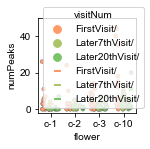

In [23]:
plt.figure(figsize=(w,h))
f = sns.stripplot(x = 'flower', y = 'numPeaks',
                  data = SweepDynamics,
                  hue = 'visitNum',
                  jitter=0.25,
                  dodge=True,
                  order = ["c-1" ,"c-2", "c-3", "c-10"],
                  **stripplot_kwargs)
sns.pointplot(x="flower", y="numPeaks", 
              estimator = np.median, 
              data=SweepDynamics,
              hue = 'visitNum',
              order = ["c-1" ,"c-2", "c-3", "c-10"],
              **pointplot_kwargs)

plt.setp(f.lines,linewidth=1)
f.set(ylim=(-2, 50))
ax = f.axes

plt.savefig(r"../dataFolders/PaperPipelineOutput/Figures/v3/Paper/" + 'NumSweeps-v2.pdf')

In [71]:
SweepDynamics[SweepDynamics.numPeaks > 50]

,names,numPeaks,freq,visitNum,flower,mothname
13,c-10_m23,83,1.681759,FirstVisit/,c-10,m23
39,c-2_m13,55,0.089606,FirstVisit/,c-2,m13


In [32]:
for data in [first, seven, twenty]:
    m = data.groupby('flower')['numPeaks'].apply(np.median)
    print(m)

flower
c-1     3.0
c-10    6.0
c-2     2.0
c-3     3.5
Name: numPeaks, dtype: float64
flower
c-1     0.0
c-10    4.0
c-2     1.0
c-3     1.0
Name: numPeaks, dtype: float64
flower
c-1     0.0
c-10    2.0
c-2     1.0
c-3     1.0
Name: numPeaks, dtype: float64


In [33]:
for name, grp in SweepDynamics.groupby('flower'):
    f,p = stats.normaltest(grp['numPeaks'])
    print('%s has %.2f stats and %.15f p value' %(name,f,p))
    if p < 0.5:
        print('%s is not normally distributed' %name)
    else:
        print('%s is normally distributed' %name)

c-1 has 57.64 stats and 0.000000000000305 p value
c-1 is not normally distributed
c-10 has 64.18 stats and 0.000000000000012 p value
c-10 is not normally distributed
c-2 has 72.38 stats and 0.000000000000000 p value
c-2 is not normally distributed
c-3 has 19.93 stats and 0.000046989908259 p value
c-3 is not normally distributed


In [34]:
c1_first = SweepDynamics.loc[(SweepDynamics.flower == 'c-1') & (SweepDynamics.visitNum == 'FirstVisit/'),
                             'numPeaks'].values
c2_first = SweepDynamics.loc[(SweepDynamics.flower == 'c-2') & (SweepDynamics.visitNum == 'FirstVisit/'),
                             'numPeaks'].values
c3_first = SweepDynamics.loc[(SweepDynamics.flower == 'c-3') & (SweepDynamics.visitNum == 'FirstVisit/'),
                             'numPeaks'].values
c10_first = SweepDynamics.loc[(SweepDynamics.flower == 'c-10') & (SweepDynamics.visitNum == 'FirstVisit/'),
                             'numPeaks'].values

c1_seven = SweepDynamics.loc[(SweepDynamics.flower == 'c-1') & (SweepDynamics.visitNum == 'Later7thVisit/'),
                             'numPeaks'].values
c2_seven = SweepDynamics.loc[(SweepDynamics.flower == 'c-2') & (SweepDynamics.visitNum == 'Later7thVisit/'),
                             'numPeaks'].values
c3_seven = SweepDynamics.loc[(SweepDynamics.flower == 'c-3') & (SweepDynamics.visitNum == 'Later7thVisit/'),
                             'numPeaks'].values
c10_seven = SweepDynamics.loc[(SweepDynamics.flower == 'c-10') & (SweepDynamics.visitNum == 'Later7thVisit/'),
                             'numPeaks'].values

c1_20 = SweepDynamics.loc[(SweepDynamics.flower == 'c-1') & (SweepDynamics.visitNum == 'Later20thVisit/'),
                             'numPeaks'].values
c2_20 = SweepDynamics.loc[(SweepDynamics.flower == 'c-2') & (SweepDynamics.visitNum == 'Later20thVisit/'),
                             'numPeaks'].values
c3_20 = SweepDynamics.loc[(SweepDynamics.flower == 'c-3') & (SweepDynamics.visitNum == 'Later20thVisit/'),
                             'numPeaks'].values
c10_20 = SweepDynamics.loc[(SweepDynamics.flower == 'c-10') & (SweepDynamics.visitNum == 'Later20thVisit/'),
                             'numPeaks'].values

print(stats.kruskal(list(c1_first), list(c2_first), list(c3_first), list(c10_first)))
print(stats.kruskal(list(c1_seven), list(c2_seven), list(c3_seven), list(c10_seven)))
print(stats.kruskal(list(c1_20), list(c2_20), list(c3_20), list(c10_20)))

KruskalResult(statistic=8.096417129279377, pvalue=0.044060520261371285)
KruskalResult(statistic=20.84409944970145, pvalue=0.0001134231053567932)
KruskalResult(statistic=8.26493352326687, pvalue=0.04084218813459758)


In [32]:
subset = SweepDynamics[(SweepDynamics.visitNum == 'Later20thVisit/')] 
# SweepDynamics[(SweepDynamics.visitNum != 'Later20thVisit/') & (SweepDynamics.visitNum != 'FirstVisit/')]
# subset['Combined'] = subset['flower'].str.cat(subset['visitNum'],sep="_")

In [33]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

Subset = subset.dropna()
mc = MultiComparison(subset['numPeaks'], subset['flower'])
result = mc.tukeyhsd()
 
print(result)
print(mc.groupsunique)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   c-1   c-10   3.2308 0.2616 -1.4584   7.92  False
   c-1    c-2      0.0    0.9  -5.949  5.949  False
   c-1    c-3      1.0    0.9 -4.0706 6.0706  False
  c-10    c-2  -3.2308 0.3963 -8.7222 2.2606  False
  c-10    c-3  -2.2308 0.5421 -6.7558 2.2943  False
   c-2    c-3      1.0    0.9 -4.8205 6.8205  False
---------------------------------------------------
['c-1' 'c-10' 'c-2' 'c-3']


In [27]:
grp1 = SweepDynamics[SweepDynamics.flower == 'c-1'].numPeaks.values
grp2 = SweepDynamics[SweepDynamics.flower == 'c-2'].numPeaks.values
grp3 = SweepDynamics[SweepDynamics.flower == 'c-3'].numPeaks.values
grp4 = SweepDynamics[SweepDynamics.flower == 'c-10'].numPeaks.values

print(stats.kruskal(list(grp1), list(grp2), list(grp3), list(grp4)))

KruskalResult(statistic=26.201007575173932, pvalue=8.656433033489041e-06)


In [29]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

# Subset = subset.dropna()
mc = MultiComparison(SweepDynamics['numPeaks'], SweepDynamics['flower'])
result = mc.tukeyhsd()
 
print(result)
print(mc.groupsunique)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
   c-1   c-10   6.4227 0.0095   1.1762 11.6692   True
   c-1    c-2   1.3606    0.9  -4.2271  6.9483  False
   c-1    c-3   0.6635    0.9  -4.5611  5.8881  False
  c-10    c-2  -5.0621 0.0601 -10.2688  0.1446  False
  c-10    c-3  -5.7592 0.0119 -10.5741 -0.9443   True
   c-2    c-3  -0.6971    0.9  -5.8817  4.4875  False
-----------------------------------------------------
['c-1' 'c-10' 'c-2' 'c-3']


In [21]:
# compare first and later visit

for name, df in SweepDynamics.groupby(['flower']):
    print(name)
    df1 = df[df.visitNum == 'FirstVisit/'].numPeaks.values
    df2 = df[df.visitNum == 'Later7thVisit/'].numPeaks.values
    df3 = df[df.visitNum == 'Later20thVisit/'].numPeaks.values
    print(stats.kruskal(list(df1), list(df2), list(df3)))

c-1
KruskalResult(statistic=8.883235968246876, pvalue=0.011776868310313892)
c-10
KruskalResult(statistic=5.073209870388817, pvalue=0.07913461136916566)
c-2
KruskalResult(statistic=1.616670679785439, pvalue=0.4455992204129404)
c-3
KruskalResult(statistic=6.812999547418586, pvalue=0.033157054694000994)


In [34]:
SweepDynamics.groupby(['flower', 'visitNum']).numPeaks.median()



flower  visitNum       
c-1     FirstVisit/        3.0
        Later20thVisit/    0.0
        Later7thVisit/     0.0
c-10    FirstVisit/        6.0
        Later20thVisit/    2.0
        Later7thVisit/     4.0
c-2     FirstVisit/        2.0
        Later20thVisit/    1.0
        Later7thVisit/     1.0
c-3     FirstVisit/        3.5
        Later20thVisit/    1.0
        Later7thVisit/     1.0
Name: numPeaks, dtype: float64

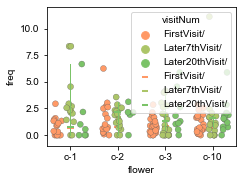

In [77]:
w = 3.4
h = w*3/4
plt.figure(figsize=(w,h))

f = sns.stripplot(x = 'flower', y = 'freq',
                  data = SweepDynamics,
                  hue = 'visitNum',
                  jitter=0.25,
                  dodge=True,
                  order = ["c-1" ,"c-2", "c-3", "c-10"],
                 **stripplot_kwargs)
sns.pointplot(x="flower", y="freq", 
              estimator = np.median, 
              data=SweepDynamics,
              hue = 'visitNum',
             order = ["c-1" ,"c-2", "c-3", "c-10"],
             **pointplot_kwargs)

plt.setp(f.lines,linewidth=1)
f.set(ylim = (-1, 12))
ax = f.axes

plt.savefig(r"../dataFolders/PaperPipelineOutput/Figures/v3/Paper/" + 'Freq-v1.pdf')

In [84]:
SweepDynamics[SweepDynamics.freq > 12]

,names,numPeaks,freq,visitNum,flower,mothname
161,c-1_m8,0,25.0,Later20thVisit/,c-1,m8


In [43]:
f = SweepDynamics.groupby('flower')['freq'].apply(np.median)
f

flower
c-1     1.250000
c-10    1.068182
c-2     1.507937
c-3     0.943396
Name: freq, dtype: float64

In [49]:
SweepDynamics['freq'].median()

1.1299795709908071

In [44]:
for name, grp in SweepDynamics.groupby('flower'):
    f,p = stats.normaltest(grp['freq'])
    print('%s has %.2f stats and %.15f p value' %(name,f,p))
    if p < 0.5:
        print('%s is not normally distributed' %name)
    else:
        print('%s is normally distributed' %name)

c-1 has 63.91 stats and 0.000000000000013 p value
c-1 is not normally distributed
c-10 has 71.27 stats and 0.000000000000000 p value
c-10 is not normally distributed
c-2 has 14.31 stats and 0.000782681531611 p value
c-2 is not normally distributed
c-3 has 15.82 stats and 0.000366242012850 p value
c-3 is not normally distributed


In [45]:
c1 = SweepDynamics.loc[SweepDynamics.flower == 'c-1', 'freq'].values
c2 = SweepDynamics.loc[SweepDynamics.flower == 'c-2', 'freq'].values
c3 = SweepDynamics.loc[SweepDynamics.flower == 'c-3', 'freq'].values
c10 = SweepDynamics.loc[SweepDynamics.flower == 'c-10', 'freq'].values
stats.kruskal(list(c1), list(c2), list(c3), list(c10))

KruskalResult(statistic=2.4251983131071215, pvalue=0.4889612021277895)

In [83]:
SweepDynamics.groupby(['visitNum', 'flower']).size()
# df.groupby(['col5', 'col2']).size()

visitNum         flower
FirstVisit/      c-1       16
                 c-10      20
                 c-2       17
                 c-3       22
Later20thVisit/  c-1        8
                 c-10      13
                 c-2        5
                 c-3        9
Later7thVisit/   c-1       13
                 c-10      17
                 c-2       16
                 c-3       20
dtype: int64

In [18]:
df1

,Unnamed: 0,names,numPeaks,freq,visitNum,flower,mothname
20,20,c-1_m10,0,1.587302,FirstVisit/,c-1,m10
21,21,c-1_m11,4,0.000000,FirstVisit/,c-1,m11
22,22,c-1_m13,6,0.000000,FirstVisit/,c-1,m13
23,23,c-1_m14,0,0.000000,FirstVisit/,c-1,m14
24,24,c-1_m16,0,1.333333,FirstVisit/,c-1,m16
25,25,c-1_m17,0,0.000000,FirstVisit/,c-1,m17
26,26,c-1_m18,3,0.884956,FirstVisit/,c-1,m18
27,27,c-1_m19,1,1.449275,FirstVisit/,c-1,m19
28,28,c-1_m1,11,0.265252,FirstVisit/,c-1,m1
29,29,c-1_m20,7,0.000000,FirstVisit/,c-1,m20


In [25]:
# Two way ANOVA

In [22]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [23]:
formula = 'numPeaks ~ C(visitNum) + C(flower) + C(visitNum):C(flower)'
model = ols(formula, SweepDynamics).fit()
aov_table = anova_lm(model, typ=2)

In [24]:
aov_table

,sum_sq,df,F,PR(>F)
C(visitNum),1495.774632,2.0,9.437335,0.000132
C(flower),1296.307932,3.0,5.452556,0.001344
C(visitNum):C(flower),463.882200,6.0,0.975595,0.443517
Residual,12996.627098,164.0,NaN,NaN
